### Project Part 2
### Alejandro Barrios(u96011930)
### Stephani Crous (u17014663)
### Phathutshedzo Maungo (u14026963)

#### Imports

In [1]:
import numpy
import tclab
from matplotlib import pyplot as plt
from tclab import TCLab, clock, Historian, Plotter, setup
%matplotlib inline

#### Parameters of Fin Bank 1 (F1)

In [2]:
AF1 = 0.0004                    # m2
AFIN1 = 0.00009                 # m2
VF1 = 0.00036                   # m3
mF1 = 0.0029                    # kg
CpF1 = 502.42                   # J.kg-1.C-1
rhoF1 = 7900                    # kg.m-3
hF1 = 10.45                     # W.m-2.K-1

#### Parameters of Fin Bank 2 (F2)

In [3]:
AF2 = 0.0004                    # m2
AFIN2 = 0.00009                 # m2
VF2 = 0.00036                   # m3
CpF2 = 502.42                   # J.kg-1.C-1
mF2 =  0.0029                   # kg
rhoF2 =  7900                   # kg.m-3
hF2 = 10.45                     # W.m-2.K-1

#### Parameters of Heater 1 (H1)

In [4]:
kH1 = 14.4/1000                     # W.m-1.K-1
AH1 = 0.00008                   # m2
LH1 = 0.0015                    # m
mH1 = 0.00019                   # kg
CpH1 = 502.42                   # J.kg-1.C-1
hH1 = 10.45                     # W.m-2.K-1

#### Parameters of Heater 2 (H2)

In [5]:
kH2 = 14.4/1000                      #W.m-1.K-1
AH2 = 0.00008                   # m2
LH2 = 0.0015                    # m
mH2 = 0.00019                   # kg
CpH2 = 502.42                   # J.kg-1.C-1
hH2 = 10.45                     # W.m-2.K-1

#### Parameters of Sensor 1 (S1)

In [6]:
AS1 = 0.000016                  # m2
mS1 = 0.00025                   # kg
CpS1 = 502.42                   # J.kg-1.C-1
hS1 = 10.45                     # W.m-2.K-1

#### Parameters of Sensor 2 (S2)

In [7]:
AS2 = 0.000016                  # m2
mS2 = 0.00025                   # kg
CpS2 = 502.42                   # J.kg-1.C-1
hS2 = 10.45                     # W.m-2.K-1

#### Other Parameters

In [8]:
alpha1 = 0.01                    # W
alpha2 = 0.075                   # W                    
h_amb = 10.45                    # W.m-2.K-1
T_amb = 298.15                     
E = 0.85                         # Emissivity
sigma = 5.67*(10**-8)            # Stefan-Boltzmann constant
rho_ss = 7900                    # Density of stainless steel (kg m-3)

#### Model

In [9]:
def Q_rect(t, M0, M1, M2, ts1, ts2):
    if t < ts1:
        return M0
    
    elif ts1<t<ts2:
        return M1
    
    else:
        return M2
    
def Q_step(t, M0, M1, ts1):
    if t < ts1:
        return M0
    else:
        return M1

In [27]:
# Differential Equations

def diff(t, T):
    TF1, TF2, TH1, TH2, TS1, TS2 = T
    QIN1 = Q_step(t, 0, 100, 30)
    QIN2 = 0
        
    # Fin Equations

    Qconv_1 = h_amb*AF1*(TF1 - T_amb)
    Qconv_2 = h_amb*AF2*(TF2 - T_amb)

    Qcond_1 = ((kH1*AH1)/LH1)*(TH1 - TF1)#QH1_F1
    Qcond_2 = ((kH2*AH2)/LH2)*(TH2 - TF2)#QH2_F2

    Qrad_1 = E*sigma*AF1*((TF1**4) - (T_amb**4))
    Qrad_2 = E*sigma*AF2*((TF2**4) - (T_amb**4))

    Qconv_12 = h_amb*(AFIN1 + AFIN2)*(TF1 - TF2)
    Qrad_12 = E*sigma*(AFIN1 + AFIN2)*((TF1**4) - (TF2**2))
    
    # Heater Equations

    QH1_F1 = ((kH1*AH1)/LH1)*(TH1 - TF1)
    QH2_F2 = ((kH2*AH2)/LH2)*(TH2 - TF2)

    QH1_S1 = ((kH1*AH1)/LH1)*(TH1 - TS1)
    QH2_S2 = ((kH2*AH2)/LH2)*(TH2 - TS2)

    QH1_conv = hH1*AH1*(TH1 - T_amb)
    QH2_conv = hH2*AH2*(TH2 - T_amb)

    QH1_rad = E*sigma*AH1*((TH1**4) - (T_amb**4))
    QH2_rad = E*sigma*AH2*((TH2**4) - (T_amb**4))
    
    # Sensor Equations

    QS1_cond = QH1_S1
    QS2_cond = QH2_S2

    QS1_conv = hS1*AS1*(TS1 - T_amb)
    QS2_conv = hS2*AS2*(TS2 - T_amb)

    QS1_rad = E*sigma*AS1*((TS1**4) - (T_amb**4))
    QS2_rad = E*sigma*AS2*((TS2**4) - (T_amb**4))
    
    # Differential Equations
    
    dTF1dt = (1/(mF1*CpF1))*(-Qconv_1 - Qrad_1 + Qcond_1 - Qconv_12 - Qrad_12)
    dTF2dt = (1/(mF2*CpF2))*(-Qconv_2 - Qrad_2 + Qcond_2 + Qconv_12 + Qrad_12)

    dTH1dt = (1/(mH1*CpH1))*(-QH1_F1 - QH1_S1 - QH1_conv - QH1_rad + alpha1*QIN1)
    dTH2dt = (1/(mH2*CpH2))*(-QH2_F2 - QH2_S2 - QH2_conv - QH2_rad + alpha2*QIN2)

    dTS1dt = (1/(mS1*CpS1))*(QS1_cond - QS1_rad - QS1_conv)
    dTS2dt = (1/(mS2*CpS2))*(QS2_cond - QS2_rad - QS2_conv)

    return dTF1dt, dTF2dt, dTH1dt, dTH2dt, dTS1dt, dTS2dt

In [28]:
TCLab = setup(connected = False, speedup = 1)
tfinal = 150
t_step = 1

In [29]:
tspan = []

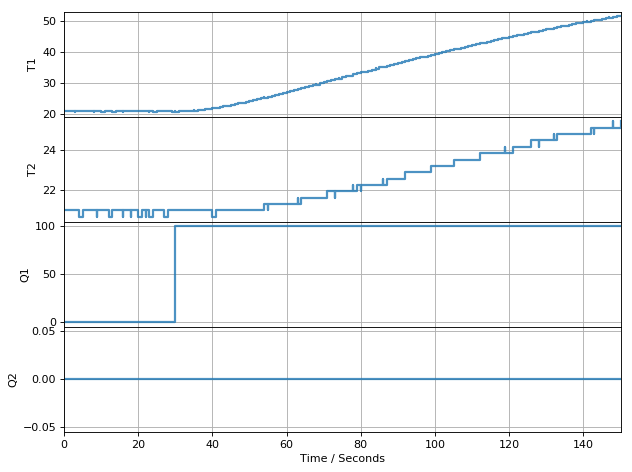

TCLab Model disconnected successfully.


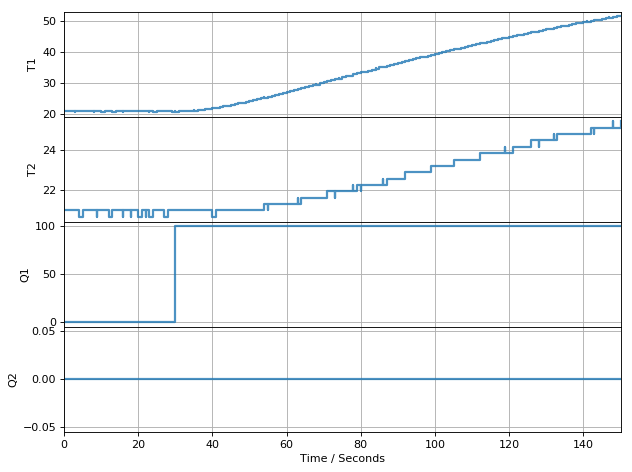

In [30]:
with TCLab() as lab:
    hist = Historian(lab.sources)
    p = Plotter(hist, tfinal)
    dt = t_step
    To = [298.15, 298.15, 298.15, 298.15, 298.15, 298.15]
    TF1, TF2, TH1, TH2, TS1, TS2 = To
    TS1s = []
    Tlab1 = []

    for t in tclab.clock(tfinal, t_step):
        
        lab.Q1(Q_step(t, 0, 100, 30))
        lab.Q2(0)

        To = TF1, TF2, TH1, TH2, TS1, TS2 
        dTF1dt, dTF2dt, dTH1dt, dTH2dt, dTS1dt, dTS2dt = diff(t, To)

        TF1 += dTF1dt*dt
        TF2 += dTF2dt*dt
        TH1 += dTH1dt*dt
        TH2 += dTH2dt*dt
        TS1 += dTS1dt*dt
        TS2 += dTS2dt*dt

        To = TF1, TF2, TH1, TH2, TS1, TS2
        TS1s.append(TS1-273.15)
        Tlab1.append(lab.T1)
        tspan.append(t)
        hist.update(t)
        p.update(t)

In [ ]:
TS1s

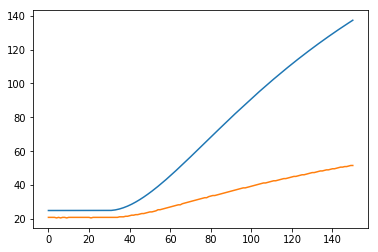

In [31]:
plt.plot(tspan, TS1s)
plt.plot(tspan, Tlab1)